In [1]:
import os
import pandas as pd

Loading data from the folder

In [ ]:
# Setting up path to load file
current_dir = os.getcwd()
csv_filename = 'data.csv'  
csv_path = os.path.join(current_dir, csv_filename)

# Initialize counter
bad_line_counter = 0

# Define a function to handle bad lines
def handle_bad_line(bad_line):
    global bad_line_counter
    bad_line_counter += 1
    return None  # Skip the bad line

# Read it in chunks due to huge size
chunk_size = 1_500_000

# Keep only relevant columns, remove ones with lots of NaN values
# LSOA name removed due to redundance
# Last outcome category removed due to high number of NaN values: 87 482 715 / 149 351 274 
# Context removed due to high number of NaN values: 144 750 473 / 149 351 274 
# Crime ID removed due to high number of NaN values: 5 781 005 / 27 205 384 (London)

columns_to_keep = ['Month', 'Reported by', 'Falls within', 'Latitude', 'Longitude', 'Location', 'LSOA code', 'Crime type']
chunks = pd.read_csv(csv_path, 
                     chunksize=chunk_size,
                     usecols=columns_to_keep,
                     engine='python', 
                     on_bad_lines=handle_bad_line)

dfs = []
for i, chunk in enumerate(chunks):

    # Removing NaN values from certain columns
    # Coordinates because it is not possible to find out then if it is in london or not
    # LSOA because it is only 6 values from London, hard to later assign police officers
    chunk = chunk.dropna(subset=['Latitude', 'Longitude', 'LSOA code'])

    # Keep only rows inside London's coordinated obtained from Wikipedia
    lat_min, lat_max = 51.2867602, 51.6918741
    lon_min, lon_max = -0.5103751, 0.3340155

    chunk = chunk[
        (chunk['Latitude'] >= lat_min) & (chunk['Latitude'] <= lat_max) &
        (chunk['Longitude'] >= lon_min) & (chunk['Longitude'] <= lon_max)
    ]
    # Printing progress
    print(f"Processing chunk {i+1}...")
    dfs.append(chunk)

df_london = pd.concat(dfs, ignore_index=True)

print(f"Loaded {len(df_london)} good rows.")
print(f"Skipped {bad_line_counter} bad rows.")

Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Processing chunk 36...
Processing chunk 37...
Processing chunk 38...
Processing chunk 39...
Processing chunk 40...
Processing chunk 41...
Processing chunk 42...
Processing chunk 43...
Processing chunk 44.

Printing head to see the Data Frame

In [22]:
df_london.head()

,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,Crime type
0,2010-12,British Transport Police,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Anti-social behaviour
1,2010-12,British Transport Police,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Anti-social behaviour
2,2010-12,British Transport Police,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime
3,2010-12,British Transport Police,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime
4,2010-12,British Transport Police,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime


Counting NaN values 

In [21]:
def count_nans(df):
    """
    Count NaN values in each column of a df object
    Input:
    - df: df object obtained from data
    Returns:
    - dictionary with numbers of NaN values for each column
    """
    nan_counts = df.isna().sum().to_dict()
    return nan_counts

count_nans(df_london)

{'Month': 0,
 'Reported by': 0,
 'Falls within': 0,
 'Longitude': 0,
 'Latitude': 0,
 'Location': 0,
 'LSOA code': 0,
 'Crime type': 0}

Data exploration space

In [ ]:
# Checking certain column's unique values
column_name = 'Falls within'
counts = df_london[column_name].value_counts(dropna=False).to_dict()
len(counts)

37

In [ ]:
# Check length
len(df_london)

27205378

In [ ]:
# Check where 'Reported by' and 'Falls within' are different
different_rows = df_london[df_london['Reported by'] != df_london['Falls within']]

# Print how number of different rows
len(different_rows)

Number of rows where 'Reported by' and 'Falls within' are different: 492


In [32]:
# Select rows where 'Reported by' and 'Falls within' are different
different_rows = df_london[df_london['Reported by'] != df_london['Falls within']]

# Create a dictionary: {Reported by : Falls within}
diff_dict = dict(zip(different_rows['Reported by'], different_rows['Falls within']))

# Print results
print(diff_dict)


{'Surrey Police': 'City of London Police'}


In [33]:
# Removing Reported by column due to redundancy, every value that was 'Surrey Police' will now be 'City of London Police'
df_london = df_london.drop(columns=['Reported by'])
cleaned_london_data = df_london.rename(columns={'Falls within': 'Falls within/Reported by'})

Converting df into csv file for storage

In [35]:
cleaned_london_data.to_csv('london_data.csv', index=False)

SKIP HERE FOR ANALYSIS AND EXPLORATION OF CLEANED FILE

Loading new csv file and getting it ready for future work

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

In [2]:
# Get directory and path for the csv file
current_dir2 = os.getcwd()
csv_filename2 = 'london_data.csv'  
csv_path2 = os.path.join(current_dir2, csv_filename2)

df = pd.read_csv(csv_path2)
df.head()

,Month,Falls within/Reported by,Longitude,Latitude,Location,LSOA code,Crime type
0,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Anti-social behaviour
1,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Anti-social behaviour
2,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime
3,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime
4,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime


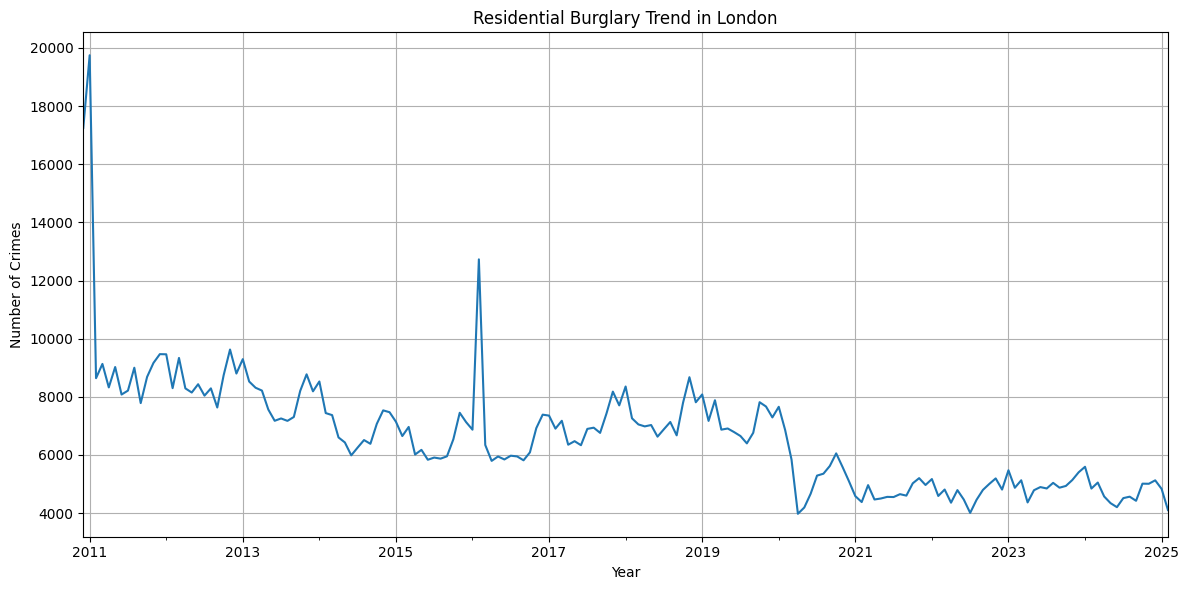

Top 10 Burglary Locations:
 Location
On or near Supermarket                            18032
On or near Parking Area                           16691
On or near Sports/Recreation Area                 11433
On or near Petrol Station                          9245
On or near Shopping Area                           9174
On or near Further/Higher Educational Building     5384
On or near Nightclub                               5035
On or near Pedestrian Subway                       4888
On or near Theatre/Concert Hall                    3880
On or near                                         3709
Name: count, dtype: int64


In [3]:
df['Month'] = pd.to_datetime(df['Month'])
df_burglary = df[df['Crime type'] == 'Burglary']
monthly_trend = df_burglary.groupby(df_burglary['Month'].dt.to_period('M')).size()

# Plot the burglary trend
monthly_trend.plot(kind='line', title='Residential Burglary Trend in London', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()

top_locations = df_burglary['Location'].value_counts().head(10)
print("Top 10 Burglary Locations:\n", top_locations)


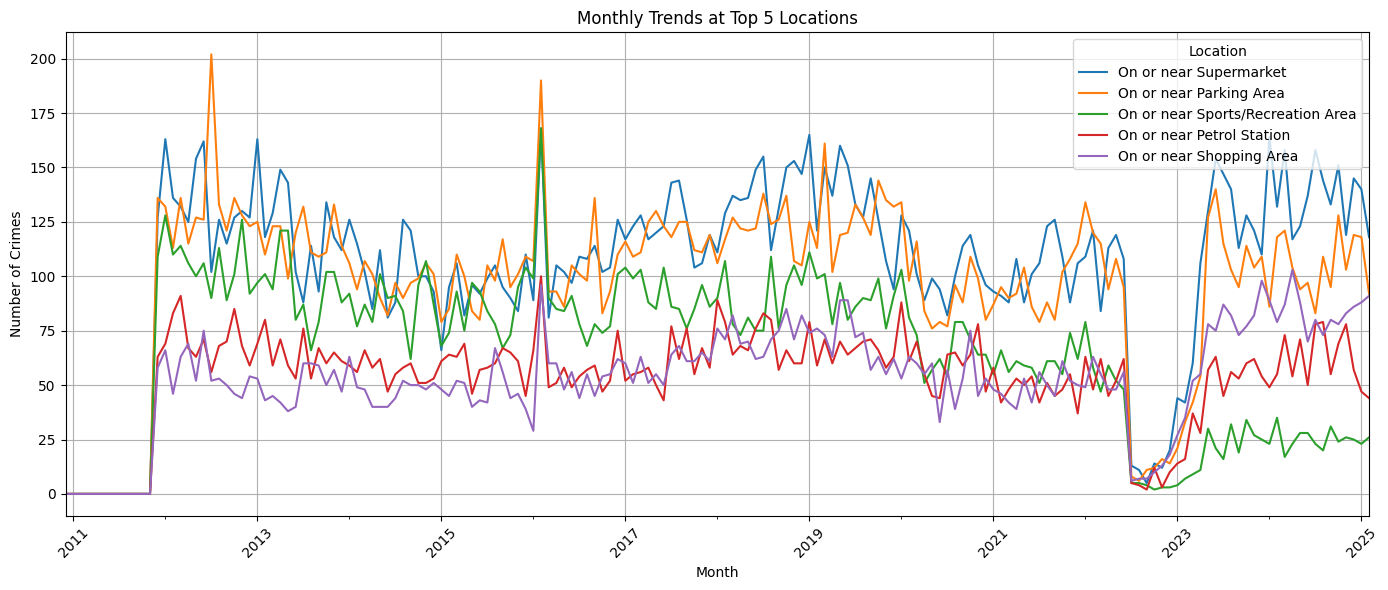

In [6]:
# Group by both Month and Location
burglary_by_location = df_burglary.groupby(['Month', 'Location']).size().reset_index(name='Crime count')

# Pivot to create a heatmap-style table
location_pivot = burglary_by_location.pivot(index='Month', columns='Location', values='Crime count').fillna(0)


top_5_locations = df_burglary['Location'].value_counts().head(5).index
location_pivot_top5 = location_pivot[top_5_locations]

# Plot trend for top 5 burglary locations
location_pivot_top5.plot(figsize=(14, 6))
plt.title('Monthly Trends at Top 5 Locations')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Location')
plt.show()


C:\Users\mariz\AppData\Local\Temp\ipykernel_19664\4225007613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_burglary['Month_num'] = df_burglary['Month'].dt.month
C:\Users\mariz\AppData\Local\Temp\ipykernel_19664\4225007613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_burglary['Month_name'] = df_burglary['Month'].dt.month_name()


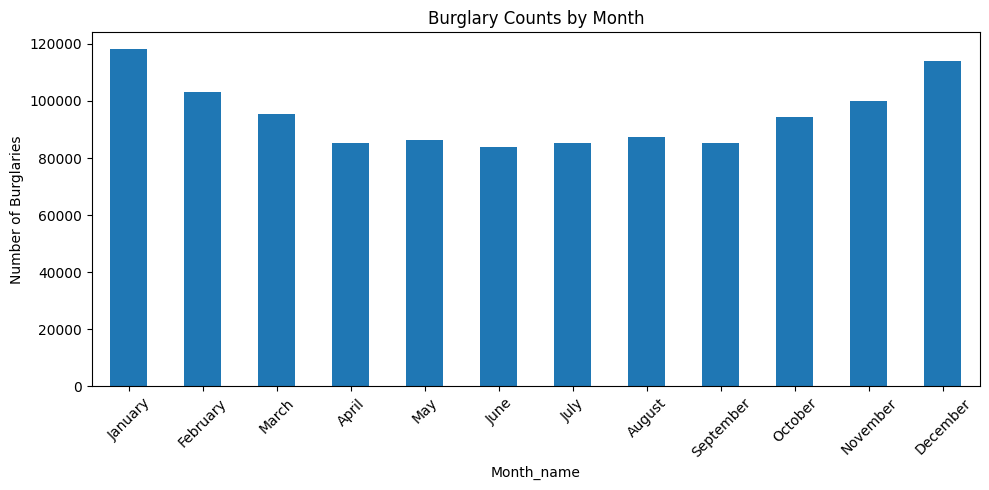

In [7]:
# Extract month and weekday from the date
df_burglary['Month_num'] = df_burglary['Month'].dt.month
df_burglary['Month_name'] = df_burglary['Month'].dt.month_name()

# Group by month
month_counts = df_burglary['Month_name'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])


#Monthly seasonality
month_counts.plot(kind='bar', title='Burglary Counts by Month', figsize=(10, 5))
plt.ylabel('Number of Burglaries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
geometry = [Point(xy) for xy in zip(df_burglary['Longitude'], df_burglary['Latitude'])]
gdf = gpd.GeoDataFrame(df_burglary, geometry=geometry)
wards = gpd.read_file('C:/Users/mariz/OneDrive - TU Eindhoven/Documents/GitHub/4CBLW00-20-MD-CBL/statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp')

In [10]:
#Run once otherwise it gives an error
gdf.set_crs(epsg=4326, inplace=True)
wards = wards.to_crs(epsg=4326)

gdf = gpd.sjoin(gdf, wards, how='left', predicate='within')
gdf.rename(columns={'ward_name_column': 'Ward'}, inplace=True)
gdf.to_csv('london_crime_with_wards.csv', index=False)


ValueError: 'index_right' cannot be a column name in the frames being joined

In [11]:
print(gdf.head())

        Month  Falls within/Reported by  Longitude  Latitude  \
28 2010-12-01  British Transport Police  -0.221375   51.5492   
29 2010-12-01  British Transport Police  -0.221375   51.5492   
30 2010-12-01  British Transport Police  -0.221375   51.5492   
31 2010-12-01  British Transport Police  -0.221375   51.5492   
39 2010-12-01  British Transport Police   0.021377   51.4138   

                      Location  LSOA code Crime type  \
28  On or near Willesden Green  E01000642   Burglary   
29  On or near Willesden Green  E01000642   Burglary   
30  On or near Willesden Green  E01000642   Burglary   
31  On or near Willesden Green  E01000642   Burglary   
39   On or near Sundridge Park  E01000823   Burglary   

                    geometry  index_right                    NAME   GSS_CODE  \
28  POINT (-0.22138 51.5492)        177.0         Willesden Green  E05000105   
29  POINT (-0.22138 51.5492)        177.0         Willesden Green  E05000105   
30  POINT (-0.22138 51.5492)        17

In [12]:
ward_crime_counts = gdf.groupby('NAME').size().reset_index(name='Crime Count')
print(ward_crime_counts.head(10))


            NAME  Crime Count
0          Abbey         2829
1     Abbey Road         1413
2     Abbey Wood         1555
3       Abingdon         1194
4  Acton Central         1770
5     Addiscombe         1674
6        Addison         1597
7     Aldborough         1797
8      Alexandra         2176
9         Alibon         1110


In [13]:
borough_crime_counts = gdf.groupby('BOROUGH').size().reset_index(name='Crime Count')
print(borough_crime_counts.head(10))


                BOROUGH  Crime Count
0  Barking and Dagenham        22936
1                Barnet        49852
2                Bexley        18485
3                 Brent        39123
4               Bromley        34061
5                Camden        39390
6        City of London         4299
7               Croydon        41394
8                Ealing        38627
9               Enfield        40757
